In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from netCDF4 import Dataset
import utils as utl

In [2]:
Nh = 96
Nt = 37
sspacing = 3
tspacing = 4

HTLS_sknots = np.arange(0,Nh,sspacing)
HTHS_sknots = np.arange(0,Nh,1)
LTHS_tknots = np.arange(0,Nh,tspacing)
Nl = len(HTLS_sknots)
Ns = len(LTHS_tknots)

N = Nt*Ns

[]

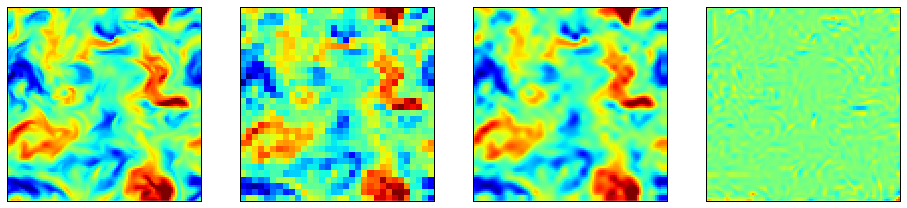

In [5]:
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')
xh = np.array(ncfile1.variables['velocity_x'][0,0:Nh,0:Nh,0])
ncfile1.close()

xl = xh[0:-1:sspacing,0:-1:sspacing]
xlf = utl.interp2(HTLS_sknots, HTLS_sknots, xl, HTHS_sknots, HTHS_sknots)
xhf = xh - xlf

fig = plt.figure(figsize=(16, 5))

ax = plt.subplot(1,4, 1)
cax = plt.imshow(xh, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())
    
ax = plt.subplot(1,4, 2)
cax = plt.imshow(xl, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,4, 3)
cax = plt.imshow(xlf, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,4, 4)
cax = plt.imshow(xhf, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

In [13]:
Np = 1 # haft number of predictor (at LR)
Do = (sspacing+1)*(sspacing+1) # dimension of the HR vector to reconstruct
patchsize_i = ((2*Np+1)*sspacing+1)
Di = patchsize_i*patchsize_i # number of LR predictors
zz_o, yy_o, zz_i, yy_i = utl.gen_grids(sspacing, 1, Nh, Np) 

Xo_tr = np.zeros((Nt*Ns*Nl*Nl, Do))
Xi_tr = np.zeros((Nt*Ns*Nl*Nl, Di))
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')

for t in range(Nt):
    count = 0
    for i in LTHS_tknots:
        xh = np.array(ncfile1.variables['velocity_x'][t,0:Nh,0:Nh,i])
        xl = xh[0:-1:sspacing,0:-1:sspacing]
        xlf = utl.interp2(HTLS_sknots, HTLS_sknots, xl, HTHS_sknots, HTHS_sknots)
        xhf = xh - xlf
        
        patches_o = xhf[yy_o,zz_o]
        patches_i = xlf[yy_i,zz_i]
        Xo_tr[(t*Ns+ count)*Nl*Nl:(t*Ns+ count + 1)*Nl*Nl,:] = np.reshape(patches_o,(Nl*Nl, Do))
        Xi_tr[(t*Ns+ count)*Nl*Nl:(t*Ns+ count + 1)*Nl*Nl,:] = np.reshape(patches_i,(Nl*Nl, Di)) 
        # reshape will take from last index toward first one
        count = count + 1
ncfile1.close()

# normalized: centered, variance 1
mea_i = np.zeros(Di)
sig_i = np.zeros(Di)
for k in range(Di):
    mea_i[k] = np.mean(Xi_tr[:,k])
    sig_i[k] = np.std(Xi_tr[:,k])
    Xi_tr[:,k] = (Xi_tr[:,k]-mea_i[k])/sig_i[k]


mea_o = np.zeros(Do)
sig_o = np.zeros(Do)
for k in range(Do):
    mea_o[k] = np.mean(Xo_tr[:,k])
    sig_o[k] = np.std(Xo_tr[:,k])
    Xo_tr[:,k] = (Xo_tr[:,k]-mea_o[k])/sig_o[k]   

(909312, 100)


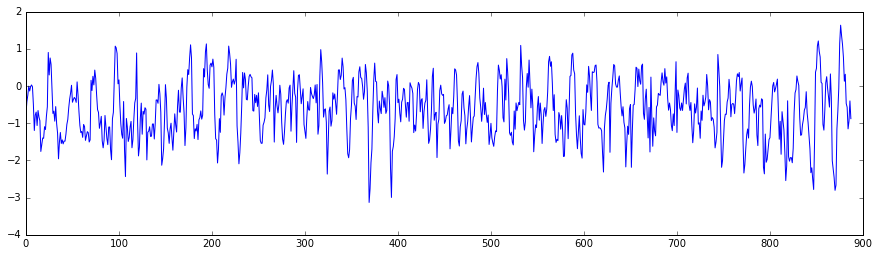

In [7]:
print np.shape(Xi_tr)
fig = plt.figure(figsize=(15, 4))
ax=plt.plot(Xi_tr[1:-1:Nl*Nl,0])

### Cross validation

In [10]:
from sklearn.linear_model import RidgeCV
param_range= np.linspace(0,10,5)
estimator = RidgeCV(alphas=param_range, fit_intercept=False, normalize=False, cv=10)
estimator.fit(Xi_tr, Xo_tr)

RidgeCV(alphas=array([  0. ,   2.5,   5. ,   7.5,  10. ]), cv=10,
    fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

2.5


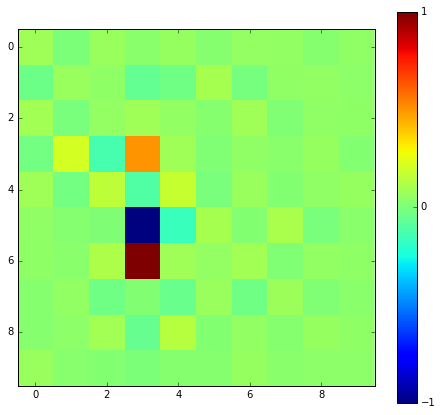

In [28]:
print estimator.alpha_
fig = plt.figure(figsize=(8, 7))
plt.imshow(np.reshape(estimator.coef_[8,:],(patchsize_i,patchsize_i)),interpolation='none')
cbar = fig.colorbar(cax, ticks=[-3, -2, -1, 0, 1, 2, 3])

In [29]:
t=1
i=1

ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')
xh = np.array(ncfile1.variables['velocity_x'][t,0:Nh,0:Nh,i])
ncfile1.close()

xl = xh[0:-1:sspacing,0:-1:sspacing]
xlf = utl.interp2(HTLS_sknots, HTLS_sknots, xl, HTHS_sknots, HTHS_sknots)
xhf = xh - xlf

patches_i = xlf[yy_i,zz_i]
patches_i = np.divide(np.reshape(patches_i,(Nl*Nl, Di)) - np.tile(mea_i, [Nl*Nl, 1]), 
                       np.tile(sig_i, [Nl*Nl, 1]))

patches_o = estimator.predict(patches_i)
patches_o = np.multiply(patches_o, np.tile(sig_o, [Nl*Nl, 1])) + np.tile(mea_o, [Nl*Nl, 1])

In [30]:
xrec_hf = np.zeros((Nh,Nh))
w = np.zeros((Nh,Nh))
xrec_hf[yy_o,zz_o] = xrec_hf[yy_o,zz_o] + np.reshape(patches_o,(Nl,Nl,4,4))
w[yy_o,zz_o] = w[yy_o,zz_o] + 1

xrec_hf = np.divide(xrec_hf, w)

[]

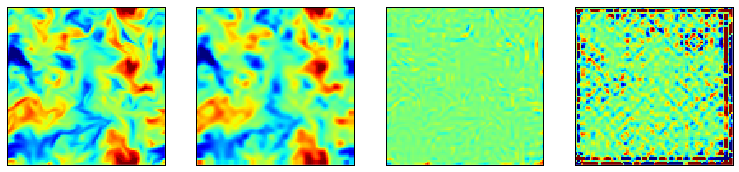

In [33]:
fig = plt.figure(figsize=(13, 5))

ax = plt.subplot(1,4, 1)
cax = plt.imshow(xh, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())
    
ax = plt.subplot(1,4, 2)
cax = plt.imshow(xlf, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,4, 3)
cax = plt.imshow(xhf, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,4, 4)
cax = plt.imshow(xrec_hf, interpolation='none',clim=[-0.1,0.1],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

In [7]:
print mea_h
print sig_h

[ -1.29917810e-04  -2.01523196e-04  -1.61589533e-04  -1.29917810e-04
   1.14697937e-04   4.47963852e-05   6.47302916e-05   1.14697937e-04
   9.35206108e-05   1.05993339e-04   6.92919550e-05   9.35206108e-05
  -1.29917810e-04  -2.01523196e-04  -1.61589533e-04  -1.29917810e-04]
[ 1.23310382  1.23310531  1.23331062  1.23310382  1.23316884  1.23335016
  1.23349577  1.23316884  1.2335186   1.23351156  1.23345104  1.2335186
  1.23310382  1.23310531  1.23331062  1.23310382]
